In [1]:
from copy import deepcopy as copy
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from numpy import shape
from math import log, sqrt, exp, pi
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation

import tensorflow as tf
from tensorflow import keras 
from copy import deepcopy as copy
import IPython.display as ipd 
import importlib
import partitionlib as ptl

In [237]:
X = pd.read_csv("options.csv", error_bad_lines=False)
X = X.drop(columns=['OptionExt','OptionSymbol','AKA','OptionSymbol','Exchange', 'OpenInterest', 'Last', 'Bid', 'Ask', 'DataDate', 'High', 'Low', 'Close', 'Volume', 'Adj Close'
                   ,'Strike', 'IV', 'InterestRate'])
X['Expiration'] = pd.to_datetime(X['Expiration']).sub(pd.Timestamp('01/02/2018')).dt.days
X['Expiration'] = X['Expiration'].apply(lambda x: x / 365)
#X['DataDate'] = pd.to_datetime(X['DataDate']).sub(pd.Timestamp('01/02/2018')).dt.days
X['Type'] = (X['Type'] != 'call').astype(int)
K = pd.get_dummies(X['UnderlyingSymbol'])
dic = {'AMZN': 0, 'F':1, 'FXI':2,'GE': 3, 'MSFT':4, 'NFLX':5 ,'QCOM': 6, 'UVXY': 7,'VIX': 8, 'XLF': 9 }
X['UnderlyingSymbol'] = X['UnderlyingSymbol'].apply(lambda x: dic[x]) 
X = X.dropna()
T = X['Open'].copy()
X = X.drop(columns=['Open'])
X

,UnderlyingSymbol,UnderlyingPrice,Type,Expiration,Delta,Gamma,Theta,Vega
0,5,201.07,0,0.008219,1.0000,0.0000,-2.2535,0.0000
1,5,201.07,1,0.008219,0.0000,0.0000,0.0000,0.0000
2,5,201.07,0,0.008219,1.0000,0.0000,-2.3340,0.0000
3,5,201.07,1,0.008219,0.0000,0.0000,0.0000,0.0000
4,5,201.07,0,0.008219,1.0000,0.0000,-2.4145,0.0000
...,...,...,...,...,...,...,...,...
364715,7,81.73,1,3.038356,-0.3769,0.0030,-8.4212,42.4784
364716,7,81.73,0,3.038356,0.4698,0.0037,-8.6118,43.8514
364717,7,81.73,1,3.038356,-0.3846,0.0030,-8.3665,42.6961
364718,7,81.73,0,3.038356,0.4610,0.0037,-8.6191,43.8372


In [238]:
X = X[X.UnderlyingSymbol == 5]
X = X.drop(columns=['UnderlyingSymbol'])
X

,UnderlyingPrice,Type,Expiration,Delta,Gamma,Theta,Vega
0,201.07,0,0.008219,1.0000,0.0000,-2.2535,0.0000
1,201.07,1,0.008219,0.0000,0.0000,0.0000,0.0000
2,201.07,0,0.008219,1.0000,0.0000,-2.3340,0.0000
3,201.07,1,0.008219,0.0000,0.0000,0.0000,0.0000
4,201.07,0,0.008219,1.0000,0.0000,-2.4145,0.0000
...,...,...,...,...,...,...,...
27873,270.30,1,2.041096,-0.7786,0.0020,-5.4821,112.4576
27874,270.30,0,2.041096,0.2073,0.0020,-11.2536,108.2261
27875,270.30,1,2.041096,-0.7836,0.0020,-5.3547,110.9733
27876,270.30,0,2.041096,0.1968,0.0019,-10.8946,104.9135


In [239]:
T = pd.DataFrame(T)
T

,Open
0,196.100006
1,196.100006
2,196.100006
3,196.100006
4,196.100006
...,...
364715,83.080002
364716,83.080002
364717,83.080002
364718,83.080002


In [118]:
def partition_data(X, T):
    data, targets = ptl.partition(copy(X.values), copy(T.values))
    Xtrain, Xtest = data
    Ttrain, Ttest = targets
    return Xtrain, Xtest, Ttrain, Ttest

def standardize(Y, T, std):
    return (X-mean)/std

def plot_fit(Y, T, title=None):
    plt.plot(T, label="Target")
    plt.plot(Y, linewidth=3, label="Prediction")
    plt.legend()
    plt.ylabel("SO2")
    plt.xlabel("Samples")
    plt.title(title)
    rmse = np.sqrt(np.mean((Y-T)**2))
    print("RMSE: {}".format(rmse))

In [240]:
Xtrain, Xtest, Ttrain, Ttest = partition_data(X, T)
N, D = X.shape
Ntrain, Ntest = Xtrain.shape[0], Xtest.shape[0]
print("Train data shape: {}".format(Xtrain.shape))
print("Train target shape: {}".format(Ttrain.shape))
print("Test data shape: {}".format(Xtest.shape))
print("Test target shape: {}".format(Ttest.shape))
print("Number of total samples: {}".format(N))
print("Number of total features: {}".format(D))
print("Number of training samples: {}".format(Ntrain))
print("Number of testing samples: {}".format(Ntest))
pd.DataFrame(Xtrain).describe()

Train data shape: (22302, 7)
Train target shape: (22302, 1)
Test data shape: (5576, 7)
Test target shape: (5576, 1)
Number of total samples: 27878
Number of total features: 7
Number of training samples: 22302
Number of testing samples: 5576


,0,1,2,3,4,5,6
count,22302.000000,22302.000000,22302.000000,22302.000000,22302.000000,22302.000000,22302.000000
mean,236.404065,0.502152,0.458750,0.175230,0.005041,-24.186661,26.181429
std,28.511341,0.500007,0.585872,0.605678,0.007223,42.505721,33.746470
min,201.070000,0.000000,0.008219,-1.000000,0.000000,-1247.244100,0.000000
25%,212.520000,0.000000,0.104110,-0.172600,0.000300,-30.261650,0.901900
50%,221.230000,1.000000,0.161644,0.000000,0.002900,-11.927700,12.941300
75%,269.740000,1.000000,0.449315,0.821625,0.007200,-3.187875,34.878625
max,284.590000,1.000000,2.041096,1.000000,0.133100,5.929600,159.132300


In [258]:
n1 = 32
n2 = 64
n3 = 128
n4 = 256
n5 = 1024
n6 = 2048
nEpochs = 300
bSize = 32

openRateModel = keras.Sequential([keras.layers.Input(shape=(D,)),
    keras.layers.Dense(units=n1, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=n2, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=n3, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=n4, activation='sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=n5, activation='softmax'),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=n6),
    keras.layers.Dense(1)])

openRateModel.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_458 (Dense)            (None, 32)                256       
_________________________________________________________________
dropout_233 (Dropout)        (None, 32)                0         
_________________________________________________________________
dense_459 (Dense)            (None, 64)                2112      
_________________________________________________________________
dropout_234 (Dropout)        (None, 64)                0         
_________________________________________________________________
dense_460 (Dense)            (None, 128)               8320      
_________________________________________________________________
dropout_235 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_461 (Dense)            (None, 256)             

In [259]:
openRateModel.compile(loss="mse", optimizer="rmsprop", metrics=['mse', 'mae'])
history = openRateModel.fit(Xtrain, Ttrain, epochs=nEpochs, validation_split=0.2, batch_size=bSize)

Train on 17841 samples, validate on 4461 samples
Epoch 1/300
17841/17841 [==============================] - 3s 151us/sample - loss: 10505.6566 - mse: 10505.6475 - mae: 71.3691 - val_loss: 826.6637 - val_mse: 826.6636 - val_mae: 25.4791
Epoch 2/300
17841/17841 [==============================] - 2s 121us/sample - loss: 812.3587 - mse: 812.3583 - mae: 26.0215 - val_loss: 816.8050 - val_mse: 816.8049 - val_mae: 25.8829
Epoch 3/300
17841/17841 [==============================] - 2s 117us/sample - loss: 804.6148 - mse: 804.6154 - mae: 26.0124 - val_loss: 814.6819 - val_mse: 814.6819 - val_mae: 26.0178
Epoch 4/300
17841/17841 [==============================] - 2s 116us/sample - loss: 803.3165 - mse: 803.3160 - mae: 26.0070 - val_loss: 826.5357 - val_mse: 826.5356 - val_mae: 25.1879
Epoch 5/300
17841/17841 [==============================] - 2s 118us/sample - loss: 800.3272 - mse: 800.3269 - mae: 25.8621 - val_loss: 822.0366 - val_mse: 822.0366 - val_mae: 25.1299
Epoch 6/300
17841/17841 [=======

In [260]:
score = openRateModel.evaluate(Xtest, Ttest, verbose=0)
print(f'Loss Score: {score[0]} \nMSE: {score[1]} \nMAE: {score[2]}')

Loss Score: 212.70444504944462 
MSE: 212.70436096191406 
MAE: 10.547398567199707


In [261]:
Ytest = openRateModel.predict(Xtest)

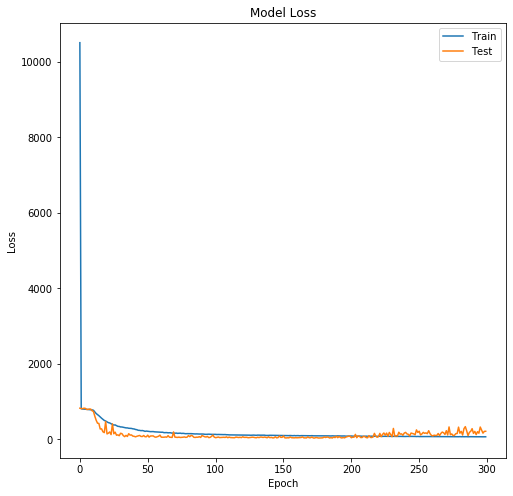

In [262]:
fig = plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

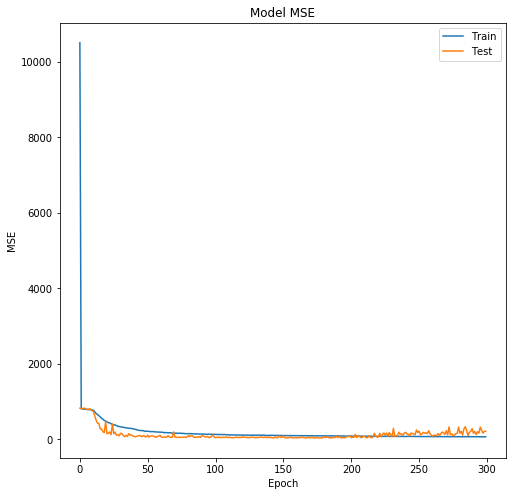

In [263]:
fig = plt.figure(figsize=(8,8))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

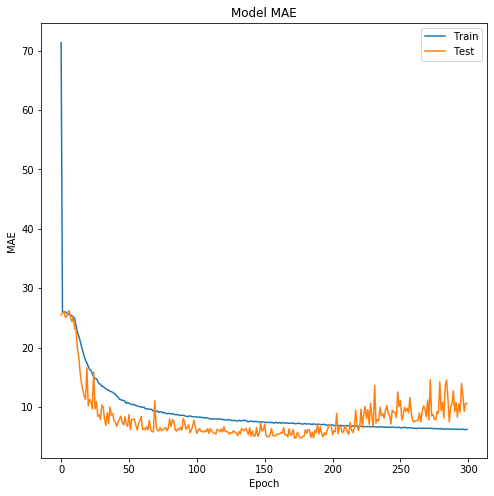

In [264]:
fig = plt.figure(figsize=(8,8))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [ ]:
"""
def load_csv(name):
    df = pd.read_csv("Stock Opening Price Data/" + name)
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%m/%d/%Y')
    df = df.set_index('Date')
    return df
"""

In [ ]:
"""
nflx = load_csv("NFLX.csv")
qcom = load_csv("QCOM.csv")
f = load_csv("F.csv")
ge = load_csv("GE.csv")
msft = load_csv("MSFT.csv")
xlf = load_csv("XLF.csv")
fxi = load_csv("FXI.csv")
vix = load_csv("VIX.csv")
amzn = load_csv("AMZN.csv")
uvxy = load_csv("UVXY.csv")
"""

In [ ]:
"""
def optionsAppend(data, name):
    options['Open'] = options.apply(lambda x: data.loc[x['DataDate']].values[0] if (x['UnderlyingSymbol'] == name) else x['Open'], axis=1)
    options['High'] = options.apply(lambda x: data.loc[x['DataDate']].values[1] if (x['UnderlyingSymbol'] == name) else x['High'], axis=1)
    options['Low'] = options.apply(lambda x: data.loc[x['DataDate']].values[2] if (x['UnderlyingSymbol'] == name) else x['Low'], axis=1)
    options['Close'] = options.apply(lambda x: data.loc[x['DataDate']].values[3] if (x['UnderlyingSymbol'] == name) else x['Close'], axis=1)
    options['Adj Close'] = options.apply(lambda x: data.loc[x['DataDate']].values[4] if (x['UnderlyingSymbol'] == name) else x['Adj Close'], axis=1)
    options['Volume'] = options.apply(lambda x: data.loc[x['DataDate']].values[5] if (x['UnderlyingSymbol'] == name) else x['Volume'], axis=1)
"""

In [ ]:
"""
optionsAppend(nflx, 'NFLX')
optionsAppend(qcom, 'QCOM')
optionsAppend(f, 'F')
optionsAppend(ge, 'GE')
optionsAppend(msft, 'MSFT')
optionsAppend(xlf, 'XLF')
optionsAppend(fxi, 'FXI')
optionsAppend(vix, 'VIX')
optionsAppend(amzn, 'AMZN')
optionsAppend(uvxy, 'UVXY')

treasury = pd.read_csv("DGS1.csv")
treasury['DATES'] = pd.to_datetime(treasury['DATE']).dt.strftime('%m/%d/%Y')
treasury = treasury.set_index('DATES')
lambda x: treasury.loc[x['DataDate']].values[1]
options['InterestRate'] = options.apply(lambda x: treasury.loc[x['DataDate']].values[1], axis=1)
"""